<a href="https://colab.research.google.com/github/miguelvneto/MVP_Sistemas_Inteligentes_ML/blob/main/MVP_Sistemas_Inteligentes_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AQUISIÇÃO DA BASE DE DADOS

In [1]:
# https://www.kaggle.com/datasets/samuelotiattakorah/lung-cancer-data
!kaggle datasets download -d samuelotiattakorah/lung-cancer-data --unzip

# após descompactada, a base de dados pode ser encontrada no seguinte diretório do Google Colab:
# /content/lung cancer survey.csv

Dataset URL: https://www.kaggle.com/datasets/samuelotiattakorah/lung-cancer-data
License(s): CC0-1.0
  0% 0.00/2.00k [00:00<?, ?B/s]
100% 2.00k/2.00k [00:00<00:00, 2.45MB/s]


# TREINO DO MODELO

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import pickle

import warnings
warnings.filterwarnings("ignore")

## Carga de Dados

In [3]:
df = pd.read_csv('/content/lung cancer survey.csv')
df['MALE'] = np.where(df['GENDER'] == 'M', 2, 1) # adiciona coluna 'MALE' para substituir a coluna 'GENDER'

# padroniza nomes das colunas
new_columns = []
for column in df.columns:
  new_column = column.strip().replace(' ', '_') # retira espaços em branco da borda, e substitui espaço por '_'
  new_columns.append(new_column)

df.columns = new_columns

In [4]:
col_features = [
       'MALE', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY',
       'PEER_PRESSURE', 'CHRONIC_DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING',
       'ALCOHOL_CONSUMING', 'COUGHING', 'SHORTNESS_OF_BREATH',
       'SWALLOWING_DIFFICULTY', 'CHEST_PAIN'
]
col_target = 'LUNG_CANCER'

# features
x = df[col_features]

# target
y = df[col_target].values

## Holdout

In [5]:
# Definindo tamanho da base utilizada para teste
test_size = 0.20
# Definindo semente para reprodutibilidade
random_state = 10
# Definindo uma semente global
np.random.seed(random_state)

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size,
    shuffle=True, random_state=random_state, stratify=y
)

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=random_state)

## Definição das Transformações de Dados

In [6]:
# Transformações que serão utilizadas

# Padronização
standard_scaler = StandardScaler()

# Normalização
min_max_scaler = MinMaxScaler()

## Definindo Modelos

In [7]:
# Vetor de modelos
modelos = []

# Criando os modelos e adicionando-os na lista de modelos
modelos.append(('KNN', KNeighborsClassifier())) # KNN
modelos.append(('DT', DecisionTreeClassifier())) # Árvore de Classificação
modelos.append(('NB', GaussianNB())) # Naive Bayes
modelos.append(('SVM', SVC())) # SVM

## Criando Pipelines

In [8]:
pipelines = []

for i, m in enumerate(modelos):
    nome = m[0]
    model = modelos[i]
    pipelines.append((nome, Pipeline([model])))
    pipelines.append((nome+' padronizado', Pipeline([('padronizacao', standard_scaler), model])))
    pipelines.append((nome+' normalizado', Pipeline([('normalizacao', min_max_scaler), model])))

## Executando os Pipelines

In [9]:
resultados = []
nomes = []

for nome, modelo in pipelines:
    cv_results = cross_val_score(modelo, X_train, y_train, cv=kfold, scoring=scoring)
    resultados.append(cv_results)
    nomes.append(nome)
    texto_resultado = f"{cv_results.mean():.4f} ({cv_results.std():.4f}) - {nome}"
    print(texto_resultado)

0.8747 (0.0451) - KNN
0.9068 (0.0647) - KNN padronizado
0.9070 (0.0671) - KNN normalizado
0.9035 (0.0442) - DT
0.8750 (0.0600) - DT padronizado
0.8955 (0.0622) - DT normalizado
0.8907 (0.0675) - NB
0.8907 (0.0675) - NB padronizado
0.8907 (0.0675) - NB normalizado
0.8745 (0.0117) - SVM
0.9233 (0.0632) - SVM padronizado
0.9192 (0.0648) - SVM normalizado


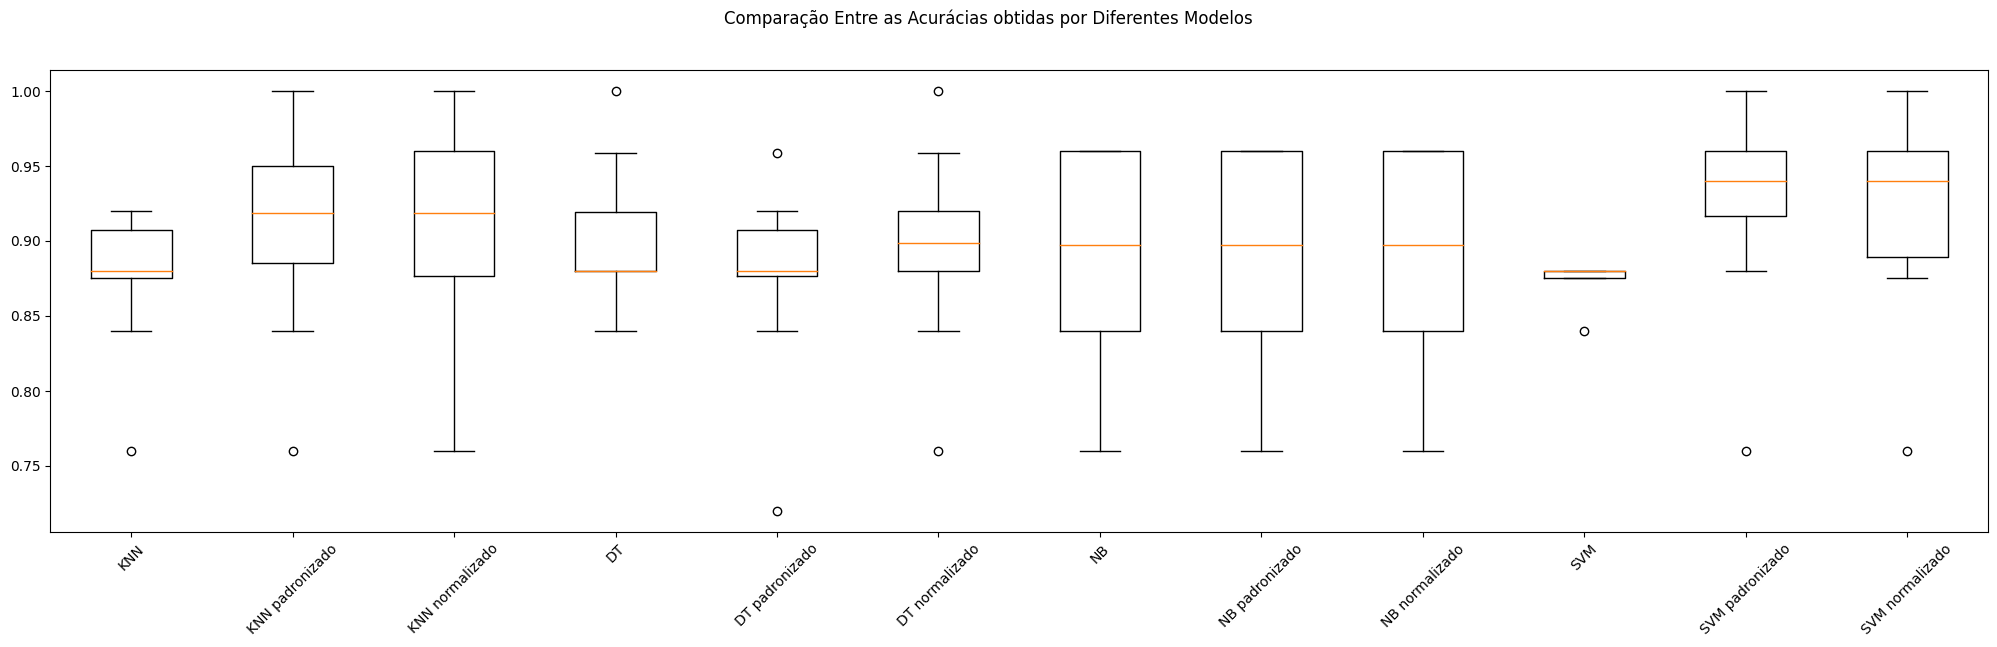

In [10]:
# Boxplot de comparação dos pipelines
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação Entre as Acurácias obtidas por Diferentes Modelos')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes, rotation=45)
plt.show()

## Otimização de Hiperparâmetros


In [11]:
# Hiperparametrização dos modelos
param_grid_knn = {
    'KNN__n_neighbors': [3, 5, 7, 9, 11],
    'KNN__weights': ['uniform', 'distance'],
    'KNN__metric': ['euclidean', 'manhattan']
}

param_grid_dt = {
    'DT__criterion': ['gini', 'entropy'],
    'DT__max_depth': [None, 5, 10, 15],
    'DT__min_samples_split': [2, 5, 10]
}

param_grid_nb = {}

param_grid_svm = {
    'SVM__C': [0.1, 1, 10],
    'SVM__kernel': ['linear', 'rbf', 'poly'],
    'SVM__gamma': ['scale', 'auto']
}

# Variáveis para armazenar resultados
grid_search_results = []
grid_search_names = []
best_pipeline = None
best_score = 0

# Rodar GridSearchCV em cada pipeline
for nome, modelo in pipelines:
    if 'KNN' in nome:
        grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid_knn, scoring=scoring, cv=kfold)
    elif 'DT' in nome:
        grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid_dt, scoring=scoring, cv=kfold)
    elif 'NB' in nome:
        grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid_nb, scoring=scoring, cv=kfold)
    elif 'SVM' in nome:
        grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid_svm, scoring=scoring, cv=kfold)
    else:
        continue

    # Treinar o modelo com GridSearchCV
    grid_search.fit(X_train, y_train)

    # Guardar o melhor resultado
    grid_search_results.append(grid_search.best_score_)
    grid_search_names.append(nome)

    # Verificar se este modelo tem a melhor acurácia
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        melhor_pipeline = grid_search.best_estimator_  # Armazena a melhor pipeline

    # Exibir o resultado
    print(f"Melhor pontuação para {nome}: {grid_search.best_score_:.4f}")
    print(f"Melhores parâmetros para {nome}: {grid_search.best_params_}")

# Exibir a pipeline de maior acurácia
print("\nPipeline com a maior acurácia:")
print(f"Melhor pipeline: {melhor_pipeline}")
print(f"Acurácia da melhor pipeline: {best_score:.4f}")

Melhor pontuação para KNN: 0.8950
Melhores parâmetros para KNN: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 3, 'KNN__weights': 'distance'}
Melhor pontuação para KNN padronizado: 0.9435
Melhores parâmetros para KNN padronizado: {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 3, 'KNN__weights': 'distance'}
Melhor pontuação para KNN normalizado: 0.9392
Melhores parâmetros para KNN normalizado: {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 3, 'KNN__weights': 'distance'}
Melhor pontuação para DT: 0.9032
Melhores parâmetros para DT: {'DT__criterion': 'entropy', 'DT__max_depth': 5, 'DT__min_samples_split': 2}
Melhor pontuação para DT padronizado: 0.9037
Melhores parâmetros para DT padronizado: {'DT__criterion': 'gini', 'DT__max_depth': 10, 'DT__min_samples_split': 2}
Melhor pontuação para DT normalizado: 0.9073
Melhores parâmetros para DT normalizado: {'DT__criterion': 'gini', 'DT__max_depth': 10, 'DT__min_samples_split': 5}
Melhor pontuação para NB: 0.8907
Melhores parâmetros para N

## Selecionando Pipeline de Maior Acurácia

In [12]:
cv_result = cross_val_score(melhor_pipeline, X_train, y_train, cv=kfold, scoring=scoring)

texto_resultado = f"{cv_result.mean():.4f} ({cv_result.std():.4f})"
print(texto_resultado)

0.9435 (0.0409)


## Exportação do Modelo Resultante

In [13]:
# Definindo nomes de arquivos
scaler_filename = 'scaler.pkl'
model_filename = 'model.pkl'
pipeline_filename = 'pipeline.pkl'
X_test_filename = 'x_test_dataset.csv'
y_test_filename = 'y_test_dataset.csv'

# Salvando o scaler e modelo separadamente
with open(scaler_filename, 'wb') as file:
    pickle.dump(melhor_pipeline[0], file)
with open(model_filename, 'wb') as file:
    pickle.dump(melhor_pipeline[1], file)

# Salvando o pipeline
with open(pipeline_filename, 'wb') as file:
    pickle.dump(melhor_pipeline, file)

# Salvando X_test e y_test
X_test_df = pd.DataFrame(X_test, columns=col_features)
y_test_df = pd.DataFrame(y_test, columns=[col_target])
X_test_df.to_csv(X_test_filename, index=False)
y_test_df.to_csv(y_test_filename, index=False)

# Teste do Modelo Exportado

In [14]:
# Carrega o pipeline treinado
with open(pipeline_filename, 'rb') as file:
    pipeline = pickle.load(file)

# Função para receber novos dados de entrada
def get_new_data():
    """
    Recebe novos dados do usuário para prever se tem câncer de pulmão.
    """
    print("Por favor, insira os seguintes dados:")

    male = input("Sexo (1 para Feminino, 2 para Masculino): ")
    age = input("Idade: ")
    smoking = input("Você fuma? (1 para Não, 2 para Sim): ")
    yellow_fingers = input("Tem dedos amarelados? (1 para Não, 2 para Sim): ")
    anxiety = input("Tem ansiedade? (1 para Não, 2 para Sim): ")
    peer_pressure = input("Sofre pressão dos colegas? (1 para Não, 2 para Sim): ")
    chronic_disease = input("Tem alguma doença crônica? (1 para Não, 2 para Sim): ")
    fatigue = input("Sente fadiga? (1 para Não, 2 para Sim): ")
    allergy = input("Tem alergia? (1 para Não, 2 para Sim): ")
    wheezing = input("Tem sibilos? (1 para Não, 2 para Sim): ")
    alcohol_consuming = input("Consome álcool? (1 para Não, 2 para Sim): ")
    coughing = input("Tem tosse? (1 para Não, 2 para Sim): ")
    shortness_of_breath = input("Tem falta de ar? (1 para Não, 2 para Sim): ")
    swallowing_difficulty = input("Tem dificuldade para engolir? (1 para Não, 2 para Sim): ")
    chest_pain = input("Tem dor no peito? (1 para Não, 2 para Sim): ")

    new_data = pd.DataFrame({
        'MALE': [int(male)], # subtraído 1 para ficar no padrão da base de dados
        'AGE': [int(age)],
        'SMOKING': [int(smoking)],
        'YELLOW_FINGERS': [int(yellow_fingers)],
        'ANXIETY': [int(anxiety)],
        'PEER_PRESSURE': [int(peer_pressure)],
        'CHRONIC_DISEASE': [int(chronic_disease)],
        'FATIGUE': [int(fatigue)],
        'ALLERGY': [int(allergy)],
        'WHEEZING': [int(wheezing)],
        'ALCOHOL_CONSUMING': [int(alcohol_consuming)],
        'COUGHING': [int(coughing)],
        'SHORTNESS_OF_BREATH': [int(shortness_of_breath)],
        'SWALLOWING_DIFFICULTY': [int(swallowing_difficulty)],
        'CHEST_PAIN': [int(chest_pain)]
    })

    return new_data

# Obtenha novos dados do usuário
new_data = get_new_data()

# Faz a previsão com o pipeline
prediction = pipeline.predict(new_data)

# Exibe o resultado da previsão
if prediction[0] == 'YES':
    print("Previsão: Alta probabilidade de Câncer de Pulmão.")
else:
    print("Previsão: Baixa probabilidade de Câncer de Pulmão.")


Por favor, insira os seguintes dados:
Sexo (1 para Feminino, 2 para Masculino): 2
Idade: 30
Você fuma? (1 para Não, 2 para Sim): 2
Tem dedos amarelados? (1 para Não, 2 para Sim): 2
Tem ansiedade? (1 para Não, 2 para Sim): 2
Sofre pressão dos colegas? (1 para Não, 2 para Sim): 1
Tem alguma doença crônica? (1 para Não, 2 para Sim): 1
Sente fadiga? (1 para Não, 2 para Sim): 2
Tem alergia? (1 para Não, 2 para Sim): 2
Tem sibilos? (1 para Não, 2 para Sim): 2
Consome álcool? (1 para Não, 2 para Sim): 2
Tem tosse? (1 para Não, 2 para Sim): 2
Tem falta de ar? (1 para Não, 2 para Sim): 2
Tem dificuldade para engolir? (1 para Não, 2 para Sim): 2
Tem dor no peito? (1 para Não, 2 para Sim): 2
Previsão: Alta probabilidade de Câncer de Pulmão.


# testes

In [15]:
nd = new_data.copy()
nd['LUNG_CANCER'] = prediction[0]
nd

,MALE,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC_DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL_CONSUMING,COUGHING,SHORTNESS_OF_BREATH,SWALLOWING_DIFFICULTY,CHEST_PAIN,LUNG_CANCER
0,2,30,2,2,2,1,1,2,2,2,2,2,2,2,2,YES


In [19]:
import sqlite3
import pandas as pd

# Conectar ao banco de dados (ou criar se não existir)
nome_database = 'lung_cancer_predictions.db'
nome_tabela = 'predictions'

In [20]:
conn = sqlite3.connect(nome_database)
cursor = conn.cursor()

# Criar tabela se não existir
cursor.execute(f'''
    CREATE TABLE IF NOT EXISTS {nome_tabela} (
        ID INTEGER PRIMARY KEY AUTOINCREMENT,
        MALE INTEGER,
        AGE INTEGER,
        SMOKING INTEGER,
        YELLOW_FINGERS INTEGER,
        ANXIETY INTEGER,
        PEER_PRESSURE INTEGER,
        "CHRONIC_DISEASE" INTEGER,
        "FATIGUE" INTEGER,
        "ALLERGY" INTEGER,
        WHEEZING INTEGER,
        "ALCOHOL_CONSUMING" INTEGER,
        COUGHING INTEGER,
        "SHORTNESS_OF_BREATH" INTEGER,
        "SWALLOWING_DIFFICULTY" INTEGER,
        "CHEST_PAIN" INTEGER,
        LUNG_CANCER TEXT
    )
''')

# Inserir dados do DataFrame 'nd' na tabela
nd.to_sql(nome_tabela, conn, if_exists='append', index=False)

# Confirmar as alterações e fechar a conexão
conn.commit()
conn.close()

In [21]:
# Conectar ao banco de dados
conn = sqlite3.connect('lung_cancer_predictions.db')
cursor = conn.cursor()

# Consulta SQL para recuperar todos os dados da tabela 'predictions'
cursor.execute("SELECT * FROM predictions")

# Obter os resultados da consulta
rows = cursor.fetchall()

# Criar um DataFrame do Pandas com os dados recuperados
df_predictions = pd.DataFrame(rows, columns=[ 'ID',
    'MALE', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE',
    'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING',
    'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
    'SWALLOWING DIFFICULTY', 'CHEST PAIN', 'LUNG_CANCER'
])

# Fechar a conexão com o banco de dados
conn.close()

# Exibir o DataFrame com os dados recuperados
df_predictions

,ID,MALE,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,2,30,2,2,2,1,1,2,2,2,2,2,2,2,2,YES
